<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/Practices/02S_Introduction_NNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Упражнение 1

В этом упражнении вам нужно будет написать свою нейронную сеть, обучить ее на датасете Breast cancer wisconsin, оценить на сколько хорошо справляется полносвязная нейронная сеть с табличными данными.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import display

import torch
import torch.utils.data as data_utils
import torch.nn.init as init

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, ensemble
from sklearn.metrics import roc_auc_score

Загрузите датасет и разделите его на обучающую, валидационную и тестовую выборки. Размер тестового датасета - 25%, размер валидационного - 25% от оставшегося

In [ ]:
data = datasets.load_breast_cancer()
print(data['data'].shape)
print(data['target'].shape)

all_train_X, X_test, all_train_y, y_test = # your code here
X_train, X_val, y_train, y_val = # your code here

Продемонстрируйте размерность датасетов


In [ ]:
# your code here

Реализуйте полносвязную модель. Не стоит делать больше 2-3 скрытых слоев.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential( # your code here)

    def forward(self, x):
        return self.model(x)

Задайте модель, критерий и оптимизатор

In [ ]:
device = torch.device("cpu") # we'll use cpu here
model = # your code here
model = mode.to(device)
optimizer = # your code here, set lr to 0.0001
criterion = nn.BCELoss() # используйте эту функцию в качестве лосса. Она нужна для бинарной классификации.

Основной цикл обучения. В модель можно подавать сразу весь датасет

In [ ]:
train_losses = []
val_losses = []
for i in range(1500):

    y_pred = model(torch.from_numpy(X_train).float().to(device))
    y_pred = y_pred.view(-1)
    loss = criterion(y_pred, torch.from_numpy(y_train).float().to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.detach().numpy())

    with torch.no_grad(): # if no OPTIMIZATION, we can skip grad calculation
        # same, but only to get validation score. NO OPTIMIZATION
        y_pred = # your code here
        y_pred = # your code here
        val_loss = # your code here
        val_losses.append(val_loss.detach().numpy())

Постройте график loss и accuracy от эпохи.

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="train")
# your code here
plt.legend()
plt.show()

Посчитайте качество на test


In [ ]:
with torch.no_grad():
        # your code here
        # your code here
roc_auc_score(y_score=y_pred, y_true=y_test)

## Упражнение 2

Нормализуйте ваши данные и посмотрите на качество нейросети в зависимости от эпохи. Что-то изменилось?

Объясните, почему

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_val_sc = # your code here
X_test_sc = # your code here

In [ ]:
device = torch.device(# your code here)
model = # your code here
optimizer = # your code here
criterion = # your code here

In [ ]:
train_losses = []
val_losses = []
for i in range(1500):
    # your code here
    with torch.no_grad():
        # your code here

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
        y_pred = model(torch.from_numpy(X_test_sc).float())
        y_pred = y_pred.view(-1).numpy()
roc_auc_score(y_score=y_pred, y_true=y_test)

## Упражнение 3

Сравните скорости обучения на cpu и gpu

In [ ]:
device = torch.device("cuda")
# your code here

In [ ]:
# your code here

In [ ]:
# your code here

In [ ]:
# your code here

## Упражнение 4

А теперь давайте сравнимся с качеством XGBoost. Не подбираем параметры кроме числа деревьев

In [ ]:
import xgboost as xgb
model = # your code here, use classifier,  n_estimators=1000, learning_rate=0.05
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)]
          # provide xgboost with validation set for automatic number of estimators selection )


In [ ]:
pred = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_score=pred, y_true=y_test)

## Упражнение 5

А теперь используем фремворк optuna для подбора параметров

Попробуйте понять, что происходит в коде. Дописывать свой код не нужно

In [ ]:
!pip install optuna

In [ ]:
import optuna

def objective(trial, train_x, train_y, val_x, val_y):

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dval = xgb.DMatrix(val_x, label=val_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "grow_policy":  trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-logloss")
    bst = xgb.train(param, dtrain, evals=[(dval, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dval)

    roc = roc_auc_score(y_true=val_y, y_score=preds)
    return roc

In [ ]:
study = optuna.create_study()
study.optimize(lambda x: objective(x, X_train, y_train, X_val, y_val), n_trials=200)

In [ ]:
model = xgb.XGBRegressor(
    objective = "binary:logistic",
    eval_metric = "logloss",
    booster= "gbtree", **study.best_params)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
pred = model.predict(X_test)
roc_auc_score(y_score=pred, y_true=y_test)

## Упражнение 6



<img src="https://raw.githubusercontent.com/aiqm/torchani/master/logo1.png">

[Статья о torchANI](https://pubs.acs.org/doi/pdf/10.1021/acs.jcim.0c00451)

Нейронная сеть torchANI обучена на основании координат атомов в составе молекулы / боле сложной системы предсказывать энергию данной системы. Для чего это нужно?

Ну например для того, чтобы из нескольких возможных положений атомов молекулы (расстояния между ними, углы) выбрать то, которое имеет наименьшую энергию и потому будет предпочтительным

В данном задании вам предлагается при помощи нейронной сети torchANI, которая умеет оценивать энергию молекул подобрать длину связей между углеродами в молекуле этана

<img src="https://upload.wikimedia.org/wikipedia/commons/7/7c/Ethane-2D.png" width="400px">

Поставим все необходимые пакеты

In [ ]:
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html
!pip install torchani
!pip install rdkit-pypi

Looking in links: https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html
     |████████████████████████████████| 10.8 MB 4.8 MB/s 
     |████████████████████████████████| 103 kB 43.6 MB/s 
     |████████████████████████████████| 20.6 MB 1.3 MB/s 


In [ ]:
import torch
import torchani
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [ ]:
device = torch.device("cuda")
model = torchani.models.ANI2x(periodic_table_index=True).to(device)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


Скачаем архив с молекулами "этана", у которых установлены разные расстояния между углеродами

In [ ]:
!wget https://kodomo.fbb.msu.ru/FBB/year_20/ml/ethane.zip
!unzip ethane.zip

--2021-11-11 18:46:29--  https://kodomo.fbb.msu.ru/FBB/year_20/ml/ethane.zip
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44635 (44K) [application/zip]
Saving to: ‘ethane.zip’

ethane.zip          100%[===================>]  43.59K   160KB/s    in 0.3s    

2021-11-11 18:46:31 (160 KB/s) - ‘ethane.zip’ saved [44635/44635]

Archive:  ethane.zip
  inflating: et_0.50.xyz             
  inflating: et_0.51.xyz             
  inflating: et_0.52.xyz             
  inflating: et_0.53.xyz             
  inflating: et_0.54.xyz             
  inflating: et_0.55.xyz             
  inflating: et_0.56.xyz             
  inflating: et_0.57.xyz             
  inflating: et_0.58.xyz             
  inflating: et_0.59.xyz             
  inflating: et_0.60.xyz             
  inflating: et_0.61.xyz             
  inflating: et_0.62.xyz             


Формат названия файла следующий - et_<расстояние между С-атомами>.xyz

In [ ]:
import os
import glob

dist2coords = {}
for path in glob.glob("et*.xyz"):
    basename = os.path.basename(path)
    name = os.path.splitext(basename)[0]
    if name == "ethan":
        continue
    dist = name.split("et_")[1]
    dist = float(dist)

    with open(path, "r") as inp:
        inp.readline()
        inp.readline()
        atoms = []
        all_coords = []
        for line in inp:
            atom, *coords = line.split()
            coords = [float(c) for c in coords]
            atoms.append(atom)
            all_coords.append(coords)
    dist2coords[dist] = all_coords

Необходимо сказать, каким атомам какие номера в таблице Менделеева соответствуют

In [ ]:
atom2id = {"C": 12, "H":1 }

Засовываем в модель атомы и координаты атомомов

In [ ]:
energies = []
dists = []
for d in sorted(dist2coords.keys()):
    coords = dist2coords[d]
    coordinates = torch.tensor([coords], requires_grad=True)
    species = torch.tensor([[atom2id[a] for a in atoms]], device=device)

    coordinates = coordinates.to(device)
    species = species.to(device)

    energy = model((species, coordinates)).energies

    dists.append(d)
    energies.append(energy.detach().float())

/usr/local/lib/python3.7/dist-packages/torchani/aev.py:236: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  pair_sizes = counts * (counts - 1) // 2


Найдем минимум энергии

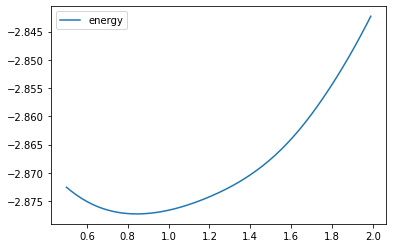

In [ ]:
import matplotlib.pyplot as plt
plt.plot(dists, energies, label="energy")
plt.legend()

In [ ]:
# your code here

In [ ]:
dist2coords

{0.5: [[0.0, 0.0, 0.0],
  [0.5, 0.0, 0.0],
  [-0.45617, 0.99646, 0.0],
  [-0.39055, -0.61187, -0.85235],
  [-1.46414, 0.05667, 0.78426],
  [1.43055, -1.08434, 0.52596],
  [0.26337, -1.11092, 1.80994],
  [1.19235, 0.38044, 1.60413]],
 0.51: [[0.0, 0.0, 0.0],
  [0.51, 0.0, 0.0],
  [-0.45617, 0.99646, 0.0],
  [-0.39055, -0.61187, -0.85235],
  [-1.45279, 0.04802, 0.78818],
  [1.44301, -1.07645, 0.51205],
  [0.28511, -1.10995, 1.80469],
  [1.20707, 0.38599, 1.5912]],
 0.52: [[0.0, 0.0, 0.0],
  [0.52, 0.0, 0.0],
  [-0.45617, 0.99646, 0.0],
  [-0.39055, -0.61187, -0.85235],
  [-1.44144, 0.03946, 0.79202],
  [1.4553, -1.06855, 0.49807],
  [0.30675, -1.10892, 1.79929],
  [1.22162, 0.39157, 1.57821]],
 0.53: [[0.0, 0.0, 0.0],
  [0.53, 0.0, 0.0],
  [-0.45617, 0.99646, 0.0],
  [-0.39055, -0.61187, -0.85235],
  [-1.43008, 0.03099, 0.79576],
  [1.46742, -1.06062, 0.48404],
  [0.32828, -1.10781, 1.79374],
  [1.23598, 0.39719, 1.56517]],
 0.54: [[0.0, 0.0, 0.0],
  [0.54, 0.0, 0.0],
  [-0.45617, 0.9964

Используя интернет, проверьте, соответствует ли полученная длина связи реальному значению